# Import Lib

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import InputSpec, Layer
from tensorflow.keras import Model
import os
try:
    from kaggle_datasets import KaggleDatasets
    REMOTE_FLAG = True
except:
    print("Load Local Dataset")
    REMOTE_FLAG = False

# Setup TPU

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.2.0


# Load Data

In [3]:
IMAGE_SIZE = [256, 256]
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    # print(dataset)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat(count=1)

    dataset = dataset.concatenate(load_dataset(filenames))

    if shuffle:
        dataset = dataset.shuffle(1000)

    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

def data_augment_2(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    # Apply jitter
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])

    # Random rotation
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3)  # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2)  # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1)  # rotate 90º

    # Random mirroring
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)

    return image

In [4]:
if REMOTE_FLAG:
    GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')
else:
    GCS_PATH = './gan-getting-started'
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment_2, batch_size=1)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment_2, batch_size=1)

# Loss

In [5]:
with strategy.scope():
    loss_object = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    # Define loss functions
    def discriminator_loss(disc_real_output, disc_generated_output):
        # compare the real image with a matrix of 1. (All Ok)
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

        # compare the fake image with a matrix of 0 (All Fake)
        generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

        total_disc_loss = (real_loss + generated_loss) / 2

        return total_disc_loss


    def generator_adversarial_loss(generated):
        return loss_object(tf.ones_like(generated), generated)


    def generator_calc_cycle_loss(real_image, cycled_image, param_lambda):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return param_lambda * loss1


    def generator_identity_loss(real_image, same_image, param_lambda):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return param_lambda * 0.5 * loss

# optimizer of each model

In [6]:
class MyDynamicLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, name):
        super().__init__()
        self.initial_learning_rate = tf.cast(initial_learning_rate, dtype=tf.float32)
        self.decay_steps = tf.cast(decay_steps, dtype=tf.float32)
        self.decay_rate = tf.cast(decay_rate, dtype=tf.float32)
        self.name = name
        
    def __call__(self, step):
        next_lr = self.initial_learning_rate * tf.math.exp(-self.decay_rate * (step / self.decay_steps))
        print(f"{self.name} current step {step}, lr {next_lr}")
        return next_lr

In [7]:
with strategy.scope():
    generator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_monet_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_photo_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Build Model

In [8]:
class CycleGan(keras.Model):
    def __init__(
            self,
            generator_monet,
            generator_photo,
            discriminator_monet,
            discriminator_photo,
            lambda_cycle=10,
            lambda_identity=10
    ):
        super(CycleGan, self).__init__()
        self.generator_monet = generator_monet
        self.generator_photo = generator_photo
        self.discriminator_monet = discriminator_monet
        self.discriminator_photo = discriminator_photo
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
            self,
            generator_monet_optimizer,
            generator_photo_optimizer,
            discriminator_monet_optimizer,
            discriminator_photo_optimizer,
            discriminator_loss,
            generator_adversarial_loss,
            generator_calc_cycle_loss,
            generator_identity_loss
    ):
        super(CycleGan, self).compile()
        self.generator_monet_optimizer = generator_monet_optimizer
        self.generator_photo_optimizer = generator_photo_optimizer
        self.discriminator_monet_optimizer = discriminator_monet_optimizer
        self.discriminator_photo_optimizer = discriminator_photo_optimizer
        self.discriminator_loss = discriminator_loss
        self.generator_adversarial_loss = generator_adversarial_loss
        self.generator_calc_cycle_loss = generator_calc_cycle_loss
        self.generator_identity_loss = generator_identity_loss

    def train_step(self, batch_data):
        monet, photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            gen_output_monet_fake = self.generator_monet(photo, training=False)
            gen_output_photo_cycle = self.generator_photo(gen_output_monet_fake, training=False)

            # monet to photo back to monet
            gen_output_photo_fake = self.generator_photo(monet, training=False)
            gen_output_monet_cycle = self.generator_monet(gen_output_photo_fake, training=False)

            # generating itself
            gen_output_monet_same = self.generator_monet(monet, training=False)
            gen_output_photo_same = self.generator_photo(photo, training=False)

            # discriminator used to check, inputing real images
            disc_out_monet_real = self.discriminator_monet(monet, training=False)
            disc_out_photo_real = self.discriminator_photo(photo, training=False)

            # discriminator used to check, inputing fake images
            disc_out_monet_fake = self.discriminator_monet(gen_output_monet_fake, training=False)
            disc_out_photo_fake = self.discriminator_photo(gen_output_photo_fake, training=False)



            # evaluates generator loss
            gen_monet_adversarial_loss = self.generator_adversarial_loss(disc_out_monet_fake)
            gen_photo_adversarial_loss = self.generator_adversarial_loss(disc_out_photo_fake)

            total_cycle_loss = (self.generator_calc_cycle_loss(monet, gen_output_monet_cycle, self.lambda_cycle)
                                + self.generator_calc_cycle_loss(photo, gen_output_photo_cycle, self.lambda_cycle))

            gen_monet_identity_loss = self.generator_identity_loss(monet, gen_output_monet_same, self.lambda_identity)
            gen_photo_identity_loss = self.generator_identity_loss(photo, gen_output_photo_same, self.lambda_identity)

            # Total generator loss = adversarial loss + cycle loss + identity loss
            total_gen_monet_loss = (gen_monet_adversarial_loss + total_cycle_loss + gen_monet_identity_loss)
            total_gen_photo_loss = (gen_photo_adversarial_loss + total_cycle_loss + gen_photo_identity_loss)

            # evaluates discriminator loss
            disc_monet_loss = self.discriminator_loss(disc_out_monet_real, disc_out_monet_fake)
            disc_photo_loss = self.discriminator_loss(disc_out_photo_real, disc_out_photo_fake)


        # Calculate the gradients for generator and discriminator
        gen_monet_gradients = tape.gradient(total_gen_monet_loss,
                                            self.generator_monet.trainable_variables)
        gen_photo_gradients = tape.gradient(total_gen_photo_loss,
                                            self.generator_photo.trainable_variables)

        disc_monet_gradients = tape.gradient(disc_monet_loss,
                                             self.discriminator_monet.trainable_variables)
        disc_photo_gradients = tape.gradient(disc_photo_loss,
                                             self.discriminator_photo.trainable_variables)

        # Apply the gradients to the optimizer
        self.generator_monet_optimizer.apply_gradients(zip(gen_monet_gradients,
                                                           self.generator_monet.trainable_variables))
        self.generator_photo_optimizer.apply_gradients(zip(gen_photo_gradients,
                                                           self.generator_photo.trainable_variables))

        self.discriminator_monet_optimizer.apply_gradients(zip(disc_monet_gradients,
                                                               self.discriminator_monet.trainable_variables))
        self.discriminator_photo_optimizer.apply_gradients(zip(disc_photo_gradients,
                                                               self.discriminator_photo.trainable_variables))

        return {
            "total_gen_monet_loss": total_gen_monet_loss,
            "total_gen_photo_loss": total_gen_photo_loss,
            "disc_monet_loss": disc_monet_loss,
            "disc_photo_loss": disc_photo_loss
        }

# Down/Up sample

In [9]:
#Build the generator preparation
with strategy.scope():
    def downsample(filters, size, apply_instancenorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                                 kernel_initializer=initializer, use_bias=not apply_instancenorm ))# when applying Normalization you already have the bias implicit
        result.add(layers.LeakyReLU())
        return result

    def upsample(filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = keras.Sequential()
        result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          use_bias=False))
        if apply_dropout:
            result.add(layers.Dropout(0.5))

        result.add(layers.ReLU())
        return result

# Resnet Block

In [10]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        if s[1] == None:
            return (None, None, None, s[3])
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        print(config)
        return config

In [11]:
class ResnetBlock(Model):

    def __init__(self, filters, strides=1):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides

        self.p1 = ReflectionPadding2D()
        self.c1 = keras.layers.Conv2D(filters, (3, 3), strides=strides, padding='valid', use_bias=False)
        self.b1 = tfa.layers.InstanceNormalization()
        self.a1 = keras.layers.Activation('relu')

        self.p2 = ReflectionPadding2D()
        self.c2 = keras.layers.Conv2D(filters, (3, 3), strides=strides, padding='valid', use_bias=False)
        self.b2 = tfa.layers.InstanceNormalization()

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.p1(inputs)
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)

        x = self.p2(x)
        x = self.c2(x)
        y = self.b2(x) + residual
        return y


# Generator

In [12]:
class Generator(Model):

    def __init__(self):  # block_list表示每个block有几个卷积层
        
        super(Generator, self).__init__()
        self.num_blocks = 9
        
        self.p1 = ReflectionPadding2D((3, 3))
        self.c1 = keras.layers.Conv2D(64, (7, 7), strides=1, padding='valid', use_bias=False)
        self.b1 = tfa.layers.InstanceNormalization()
        self.a1 = keras.layers.Activation('relu')
        
        # Two down sampling layers
        self.c2 = keras.layers.Conv2D(128, (3, 3), strides=2, padding='same', use_bias=False)
        self.b2 = tfa.layers.InstanceNormalization()
        self.a2 = keras.layers.Activation('relu')
        
        self.c3 = keras.layers.Conv2D(256, (3, 3), strides=2, padding='same', use_bias=False)
        self.b3 = tfa.layers.InstanceNormalization()
        self.a3 = keras.layers.Activation('relu')
        
        # Calc Blocks
        self.blocks = keras.models.Sequential()
        # 构建ResNet网络结构
        for block_id in range(self.num_blocks):  # 第几个resnet block
            block = ResnetBlock(256)
            self.blocks.add(block)  # 将构建好的block加入resnet
            
        # Two up Sampling layers
        self.t4 = keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', output_padding=1)
        self.b4 = tfa.layers.InstanceNormalization()
        self.a4 = keras.layers.Activation('relu')
        
        self.t5 = keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', output_padding=1)
        self.b5 = tfa.layers.InstanceNormalization()
        self.a5 = keras.layers.Activation('relu')
                
        self.p6 = ReflectionPadding2D((3, 3))
        self.c6 = keras.layers.Conv2D(3, (7, 7), strides=1, padding='valid', use_bias=False)
        self.a6 = keras.layers.Activation('tanh')
        

    def call(self, inputs):
        x = self.p1(inputs)
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        
        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        
        x = self.blocks(x)
        
        x = self.t4(x)
        x = self.b4(x)
        x = self.a4(x)
        
        x = self.t5(x)
        x = self.b5(x)
        x = self.a5(x)
        
        x = self.p6(x)
        x = self.c6(x)
        y = self.a6(x)
        return y

# Discriminator

In [13]:
# Build the discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    leaky_relu = layers.LeakyReLU()(conv)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1,
                         kernel_size = 4,
                         strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

# Train

In [14]:
with strategy.scope():
    #Create Generator and Discriminator
    generator_monet = Generator() # transforms photos to Monet-esque paintings
    generator_photo = Generator() # transforms Monet paintings to be more like photos
    discriminator_monet = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    discriminator_photo = Discriminator() # differentiates real photos and generated photos

In [15]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        generator_monet, generator_photo, discriminator_monet, discriminator_photo
    )

    cycle_gan_model.compile(
            generator_monet_optimizer = generator_monet_optimizer,
            generator_photo_optimizer = generator_photo_optimizer,
            discriminator_monet_optimizer = discriminator_monet_optimizer,
            discriminator_photo_optimizer = discriminator_photo_optimizer,
            discriminator_loss = discriminator_loss,
            generator_adversarial_loss = generator_adversarial_loss,
            generator_calc_cycle_loss = generator_calc_cycle_loss,
            generator_identity_loss = generator_identity_loss
        )

## checkpoints

In [16]:
!mkdir ../checkpoint

In [17]:
if REMOTE_FLAG:
    checkpoint_save_path = "/kaggle/working/checkpoint/CycleGAN.ckpt"
else:
    checkpoint_save_path = "./checkpoint/CycleGAN.ckpt"
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

## fit

In [18]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50,
    callbacks=[cp_callback]
)

Epoch 1/50
600/600 [==============================] - 252s 419ms/step - total_gen_monet_loss: 8.0913 - total_gen_photo_loss: 8.2102 - disc_monet_loss: 0.6848 - disc_photo_loss: 0.6752
Epoch 2/50
600/600 [==============================] - 251s 419ms/step - total_gen_monet_loss: 7.3515 - total_gen_photo_loss: 7.3746 - disc_monet_loss: 0.6413 - disc_photo_loss: 0.6533
Epoch 3/50
600/600 [==============================] - 251s 419ms/step - total_gen_monet_loss: 6.7795 - total_gen_photo_loss: 6.8005 - disc_monet_loss: 0.6421 - disc_photo_loss: 0.6447
Epoch 4/50
600/600 [==============================] - 251s 418ms/step - total_gen_monet_loss: 6.4290 - total_gen_photo_loss: 6.3751 - disc_monet_loss: 0.6365 - disc_photo_loss: 0.6473
Epoch 5/50
600/600 [==============================] - 251s 418ms/step - total_gen_monet_loss: 6.1512 - total_gen_photo_loss: 6.1402 - disc_monet_loss: 0.6401 - disc_photo_loss: 0.6450
Epoch 6/50
600/600 [==============================] - 251s 419ms/step - total_ge

# Plot

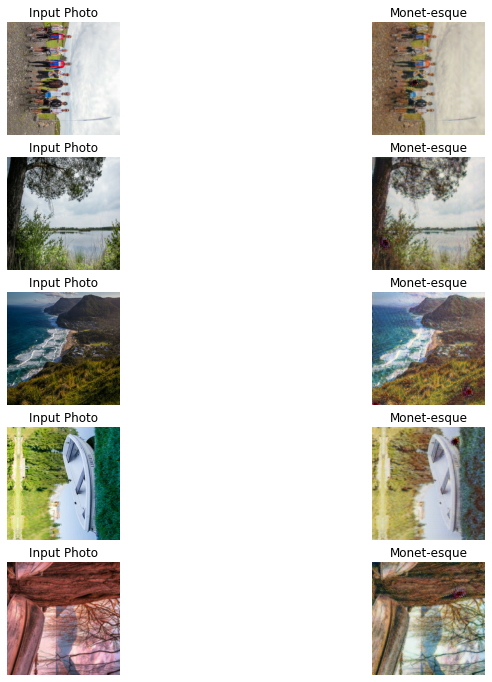

In [19]:
# Plot
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# SAVE

In [20]:
# import PIL
# ! mkdir ../images
# i = 1
# for img in photo_ds:
#     prediction = monet_generator(img, training=False)[0].numpy()
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1
    
# import shutil
# shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [21]:
import shutil
shutil.make_archive("/kaggle/working/checkpoint", 'zip', "/kaggle/checkpoint")

'/kaggle/working/checkpoint.zip'